In [1]:
import numpy as np
import scipy.stats
import pandas as pd
pd.set_option('max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

In [2]:
data = pd.read_csv('data/Invistico_Airline.csv')


In [3]:
data

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,2,4,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,3,0,2,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,2,0,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,3,4,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,3,4,3,4,2,2,0,2,4,2,5,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,satisfied,Female,disloyal Customer,29,Personal Travel,Eco,1731,5,5,5,3,2,5,2,2,3,3,4,4,4,2,0,0.0
129876,dissatisfied,Male,disloyal Customer,63,Personal Travel,Business,2087,2,3,2,4,2,1,1,3,2,3,3,1,2,1,174,172.0
129877,dissatisfied,Male,disloyal Customer,69,Personal Travel,Eco,2320,3,0,3,3,3,2,2,4,4,3,4,2,3,2,155,163.0
129878,dissatisfied,Male,disloyal Customer,66,Personal Travel,Eco,2450,3,2,3,2,3,2,2,3,3,2,3,2,1,2,193,205.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129880 non-null  object 
 1   Gender                             129880 non-null  object 
 2   Customer Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type of Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight Distance                    129880 non-null  int64  
 7   Seat comfort                       129880 non-null  int64  
 8   Departure/Arrival time convenient  129880 non-null  int64  
 9   Food and drink                     129880 non-null  int64  
 10  Gate location                      129880 non-null  int64  
 11  Inflight wifi service              1298

In [5]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Fill missing arrival delay values with column mean
    df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].mean())
    
    # Binary encoding
    df['Gender'] = df['Gender'].replace({
        'Female': 0,
        'Male': 1
    })
    df['Customer Type'] = df['Customer Type'].replace({
        'disloyal Customer': 0,
        'Loyal Customer': 1
    })
    df['Type of Travel'] = df['Type of Travel'].replace({
        'Personal Travel': 0,
        'Business travel': 1
    })
    
    # One-hot encoding
    flight_class_dummies = pd.get_dummies(df['Class'], prefix='Flight_class')
    df = pd.concat([df, flight_class_dummies], axis=1)
    df = df.drop('Class', axis=1)
    
    return df

In [6]:
X = preprocess_inputs(data)


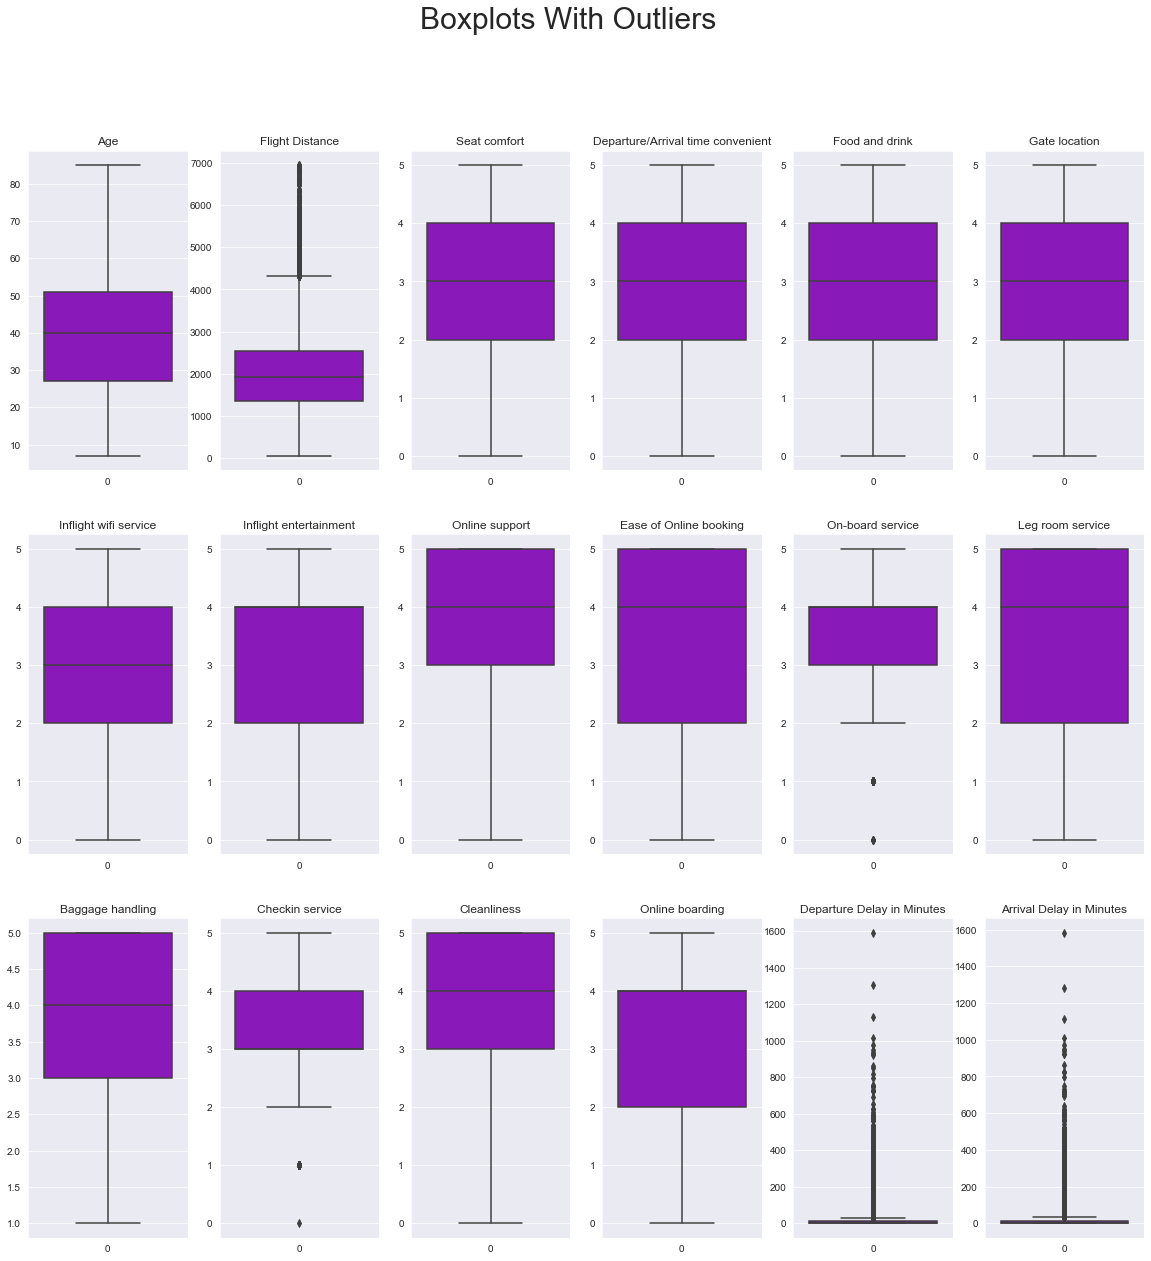

In [7]:
eda_df = X.drop('satisfaction', axis=1).copy()
nonbinary_columns = [column for column in eda_df.columns if len(eda_df[column].unique()) > 2]

plt.figure(figsize=(20, 20))

for i, column in enumerate(nonbinary_columns):
    plt.subplot(3, 6, i + 1)
    sns.boxplot(data=eda_df[column], color='darkviolet')
    plt.title(column)

plt.suptitle("Boxplots With Outliers", size=30)
plt.show()

In [8]:
def remove_outliers(df, columns, threshold):
    df = df.copy()
    
    # Calculate the lower and upper bounds on the Z distribution given a threshold value
    lower_bound = scipy.stats.norm.ppf(q=(threshold / 2), loc=0, scale=1)
    upper_bound = scipy.stats.norm.ppf(q=1 - (threshold / 2), loc=0, scale=1)
    
    # Calculate z-scores of every example in the columns specified
    outlier_df = df.loc[:, columns].copy()
    zscores = pd.DataFrame(scipy.stats.zscore(outlier_df, axis=0), index=outlier_df.index, columns=outlier_df.columns)
    
    # Get boolean arrays denoting the outlier examples
    lower_outliers = (zscores < lower_bound).any(axis=1)
    upper_outliers = (zscores >= upper_bound).any(axis=1)
    
    # Get indicies of all outlier examples
    outliers = df[pd.concat([lower_outliers, upper_outliers], axis=1).any(axis=1)].index
    
    # Drop the outliers
    df = df.drop(outliers, axis=0).reset_index(drop=True)
    print(len(outliers), "examples dropped.")
    
    return df

41258 examples dropped.


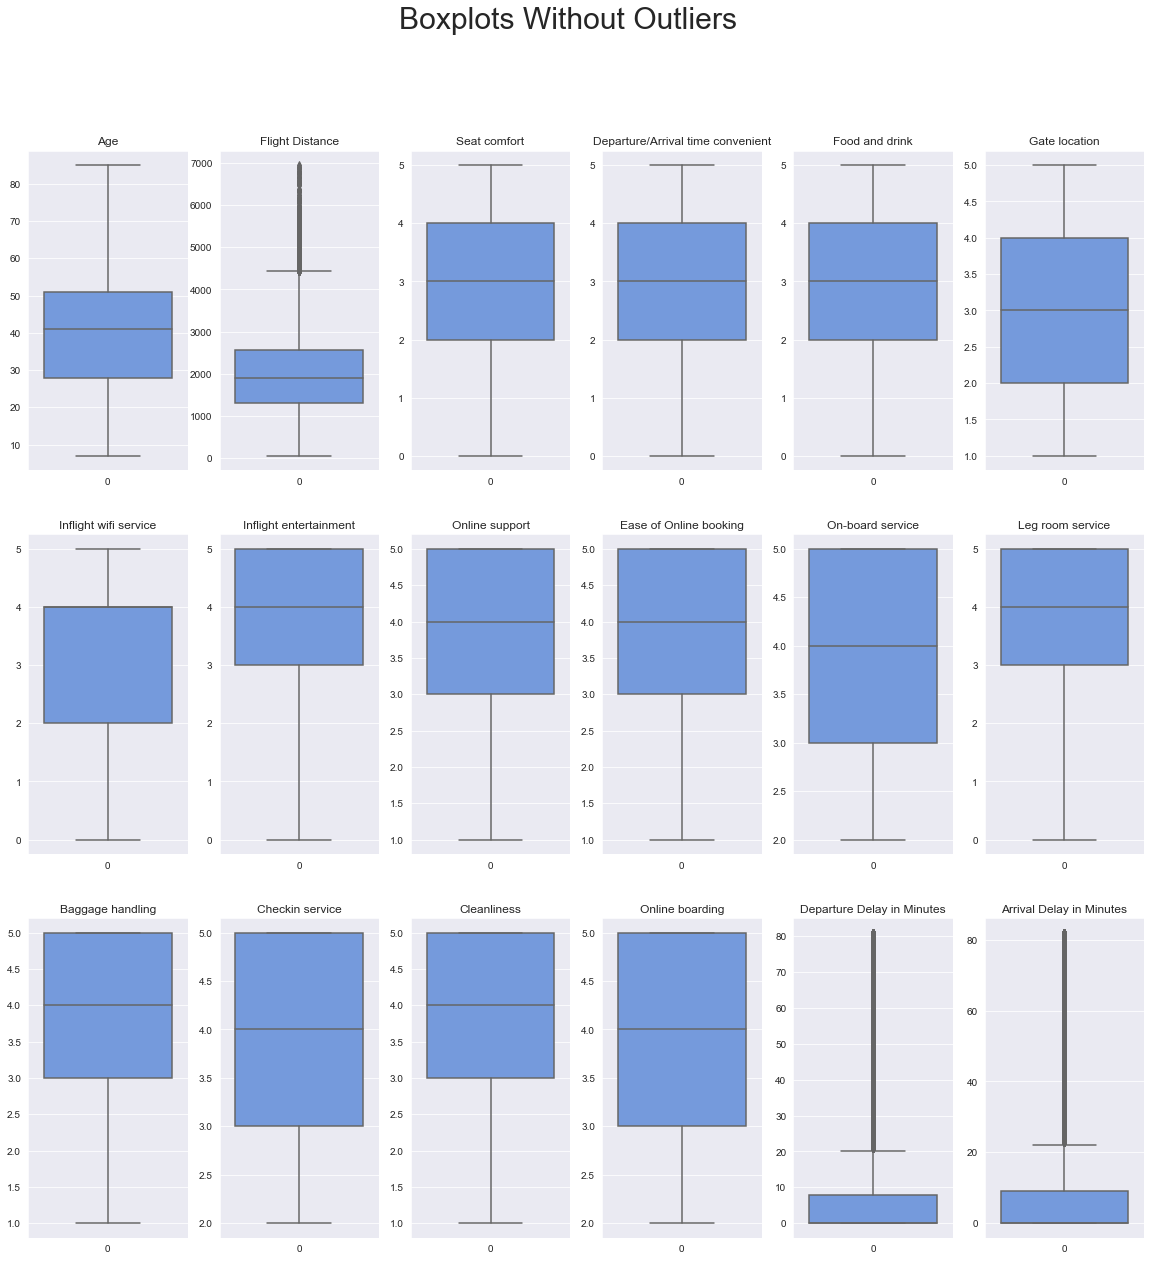

In [9]:
outliers_df = remove_outliers(
    df=X,
    columns=[
        'On-board service',
        'Checkin service',
        'Departure Delay in Minutes',
        'Arrival Delay in Minutes',
        'Online boarding'
    ],
    threshold=0.08
)

plt.figure(figsize=(20, 20))

for i, column in enumerate(nonbinary_columns):
    plt.subplot(3, 6, i + 1)
    sns.boxplot(data=outliers_df[column], color='cornflowerblue')
    plt.title(column)

plt.suptitle("Boxplots Without Outliers", size=30)
plt.show()

In [11]:
#Finalizing Model Inputs
def finalize_inputs(df, keep_outliers=True, outlier_threshold=0.05):
    df = df.copy()
    
    
    
    # Train-test Split
    train_df, test_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=1)
    
    # Remove outliers
    if keep_outliers == False:
        train_df = remove_outliers(
            train_df,
            columns=[
                'On-board service',
                'Checkin service',
                'Departure Delay in Minutes',
                'Arrival Delay in Minutes'
            ],
            threshold=outlier_threshold
        )
    
    # Split df into X and y
    y_train = train_df['satisfaction']
    y_test = test_df['satisfaction']
    X_train = train_df.drop('satisfaction', axis=1)
    X_test = test_df.drop('satisfaction', axis=1)
    
    # Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    return X_train, X_test, y_train, y_test

In [12]:
X_train1, X_test1, y_train1, y_test1 = finalize_inputs(X, keep_outliers=True)

model1 = LogisticRegression()
model1.fit(X_train1, y_train1)

print("Test Accuracy: {:.3f}%".format(model1.score(X_test1, y_test1) * 100))

Test Accuracy: 83.618%


In [31]:
from sklearn.metrics import accuracy_score

X_train2, X_test2, y_train2, y_test2 = finalize_inputs(X, keep_outliers=False, outlier_threshold=0.0000001)

model2 = LogisticRegression()
model2.fit(X_train2, y_train2)
y_pred = model2.predict(X_test2)
print(accuracy_score(y_pred,y_test2))


589 examples dropped.
0.8363361051226773


In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test2,y_pred))

              precision    recall  f1-score   support

dissatisfied       0.82      0.82      0.82     17700
   satisfied       0.85      0.85      0.85     21264

    accuracy                           0.84     38964
   macro avg       0.84      0.83      0.83     38964
weighted avg       0.84      0.84      0.84     38964



In [20]:

from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test2,y_pred)
print(conf_matrix)

[[14470  3230]
 [ 3147 18117]]
